# Analyzing Training, Validation, and Testing Sets
Plotting some distributions of the test set.

In [1]:
import sys
import os
import h5py
from collections import Counter
from progressbar import *
import re
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
#from watchmal.testing.repeating_classifier_training_utils import *
from functools import reduce

# Add the path to the parent directory to augment search for module
par_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

if par_dir not in sys.path:
    sys.path.append(par_dir)

sys.path.append("../..")
sys.path.append("..")

from short_tank_exploratory_data_analysis.exploratory_data_analysis_utils import *

%load_ext autoreload
%matplotlib inline
%autoreload 2

from IPython.display import HTML

In [2]:
import boost_histogram

## Load Data

In [3]:
# Import test events from h5 file
filtered_index = "/fast_scratch/WatChMaL/data/IWCD_fulltank_300_pe_idxs.npz"
filtered_indices = np.load(filtered_index, allow_pickle=True)
test_filtered_indices = filtered_indices['test_idxs']

original_data_path = "/data/WatChMaL/data/IWCDmPMT_4pi_fulltank_9M.h5"
f = h5py.File(original_data_path, "r")

hdf5_event_data = (f["event_data"])
original_eventdata = np.memmap(original_data_path, mode="r", shape=hdf5_event_data.shape,
                                    offset=hdf5_event_data.id.get_offset(), dtype=hdf5_event_data.dtype)

original_energies = np.array(f['energies'])
original_positions = np.array(f['positions'])
original_angles = np.array(f['angles'])
original_labels = np.array(f['labels'])

# filtered_eventdata = original_eventdata[test_filtered_indices]
test_energies = original_energies[test_filtered_indices]
test_positions = original_positions[test_filtered_indices]
test_angles = original_angles[test_filtered_indices]
test_labels = original_labels[test_filtered_indices]
f.close()

test_info = {'name':'Test Set','energies':test_energies,'positions':test_positions, 
             'angles':test_angles, 'labels':test_labels}

In [4]:
trainval_data_path='/fast_scratch/WatChMaL/data/IWCDmPMT_4pi_fulltank_9M_splits_CNN/IWCDmPMT_4pi_fulltank_9M_trainval.h5'
trainval_idxs_path='/fast_scratch/WatChMaL/data/IWCDmPMT_4pi_fulltank_9M_splits_CNN/IWCDmPMT_4pi_fulltank_9M_trainval_idxs.npz'

idxs = np.load(trainval_idxs_path,allow_pickle=True)
train_idxs = idxs['train_idxs']
val_idxs = idxs['val_idxs']

f = h5py.File(trainval_data_path,'r')
tv_hdf5_event_data = (f["event_data"])
tv_eventdata = np.memmap(trainval_data_path, mode="r", shape=tv_hdf5_event_data.shape,
                                    offset=tv_hdf5_event_data.id.get_offset(), dtype=tv_hdf5_event_data.dtype)

tv_energies = np.array(f['energies'])
tv_positions = np.array(f['positions'])
tv_angles = np.array(f['angles'])
tv_labels = np.array(f['labels'])

train_energies = tv_energies[train_idxs]
train_positions = tv_positions[train_idxs]
train_angles = tv_angles[train_idxs]
train_labels = tv_labels[train_idxs]

train_info = {'name':'Training Set','energies':train_energies,'positions':train_positions, 
              'angles':train_angles, 'labels':train_labels}

val_energies = tv_energies[val_idxs]
val_positions = tv_positions[val_idxs]
val_angles = tv_angles[val_idxs]
val_labels = tv_labels[val_idxs]
val_info = {'name':'Validation Set','energies':val_energies,'positions':val_positions, 
            'angles':val_angles, 'labels':val_labels}

In [5]:
dataset_info = [train_info,val_info,test_info]

# Specific Indexes

In [6]:
# Get dataset idxs by particle type
train_e_idxs = np.where(dataset_info[0]['labels']==1)[0]
val_e_idxs   = np.where(dataset_info[1]['labels']==1)[0]
test_e_idxs  = np.where(dataset_info[2]['labels']==1)[0]

train_g_idxs = np.where(dataset_info[0]['labels']==0)[0]
val_g_idxs   = np.where(dataset_info[1]['labels']==0)[0]
test_g_idxs  = np.where(dataset_info[2]['labels']==0)[0]

train_m_idxs = np.where(dataset_info[0]['labels']==2)[0]
val_m_idxs   = np.where(dataset_info[1]['labels']==2)[0]
test_m_idxs  = np.where(dataset_info[2]['labels']==2)[0]

# Test Plotting All PMT Charges

In [7]:
"""
import time
time0 = time.time()
plt.hist(hit_charge)
time1 = time.time()

print("Took time: ", time1 - time0)
"""

'\nimport time\ntime0 = time.time()\nplt.hist(hit_charge)\ntime1 = time.time()\n\nprint("Took time: ", time1 - time0)\n'

# Updated Left Bin Event Plots

In [8]:
dataset_info[0]['total_charge'] = np.load('./old_dataset_data/training_set_total_charge.npz',allow_pickle=True)['total_charge']
dataset_info[1]['total_charge'] = np.load('./old_dataset_data/validation_set_total_charge.npz',allow_pickle=True)['total_charge']

In [9]:
# Find all events in the leftmost bin
train_left_bin_bound = 5.94362375e02
left_train_g_idxs = train_g_idxs[dataset_info[0]['total_charge'][train_g_idxs] < train_left_bin_bound]
left_train_e_idxs = train_e_idxs[dataset_info[0]['total_charge'][train_e_idxs] < train_left_bin_bound]
left_train_m_idxs = train_m_idxs[dataset_info[0]['total_charge'][train_m_idxs] < train_left_bin_bound]

val_left_bin_bound = 5.94362375e02
left_val_g_idxs = val_g_idxs[dataset_info[1]['total_charge'][val_g_idxs] < val_left_bin_bound]
left_val_e_idxs = val_e_idxs[dataset_info[1]['total_charge'][val_e_idxs] < val_left_bin_bound]
left_val_m_idxs = val_m_idxs[dataset_info[1]['total_charge'][val_m_idxs] < val_left_bin_bound]


In [10]:
left_train_event_indices = np.concatenate((left_train_g_idxs, left_train_e_idxs, left_train_m_idxs))
left_train_event_charges = np.concatenate((dataset_info[0]['total_charge'][left_train_g_idxs], 
                                           dataset_info[0]['total_charge'][left_train_e_idxs],
                                           dataset_info[0]['total_charge'][left_train_m_idxs]))

# Event Hit Types

In [11]:
f = np.load('./old_dataset_data/dist_to_wall.npz', allow_pickle=True)

dataset_info[0]['d_to_wall'] = f['train_d_to_wall']
dataset_info[1]['d_to_wall'] = f['val_d_to_wall']
dataset_info[2]['d_to_wall'] = f['test_d_to_wall']

In [12]:
hit_type_dict = {'endcap': 0, 'barrel': 1}
f = np.load('./old_dataset_data/hit_types.npz', allow_pickle=True)

dataset_info[0]['hit_types'] = f['train_hit_types']
dataset_info[1]['hit_types'] = f['val_hit_types']
dataset_info[2]['hit_types'] = f['test_hit_types']

In [13]:
train_e_idxs = np.where(dataset_info[0]['labels']==1)[0]
val_e_idxs   = np.where(dataset_info[1]['labels']==1)[0]
test_e_idxs  = np.where(dataset_info[2]['labels']==1)[0]

train_g_idxs = np.where(dataset_info[0]['labels']==0)[0]
val_g_idxs   = np.where(dataset_info[1]['labels']==0)[0]
test_g_idxs  = np.where(dataset_info[2]['labels']==0)[0]

train_m_idxs = np.where(dataset_info[0]['labels']==2)[0]
val_m_idxs   = np.where(dataset_info[1]['labels']==2)[0]
test_m_idxs  = np.where(dataset_info[2]['labels']==2)[0]

In [14]:
# Find all endcap events
endcap_train_idxs = dataset_info[0]['hit_types'] == hit_type_dict['endcap']
endcap_val_idxs   = dataset_info[1]['hit_types'] == hit_type_dict['endcap']
endcap_test_idxs  = dataset_info[2]['hit_types'] == hit_type_dict['endcap']

# Find all barrel events
barrel_train_idxs = dataset_info[0]['hit_types'] == hit_type_dict['barrel']
barrel_val_idxs   = dataset_info[1]['hit_types'] == hit_type_dict['barrel']
barrel_test_idxs  = dataset_info[2]['hit_types'] == hit_type_dict['barrel']


In [15]:
endcap_train_e = (dataset_info[0]['d_to_wall'][train_e_idxs])[endcap_train_idxs[train_e_idxs]]
endcap_val_e   = (dataset_info[1]['d_to_wall'][val_e_idxs])[endcap_val_idxs[val_e_idxs]]
endcap_test_e  = (dataset_info[2]['d_to_wall'][test_e_idxs])[endcap_test_idxs[test_e_idxs]]

endcap_train_g = (dataset_info[0]['d_to_wall'][train_g_idxs])[endcap_train_idxs[train_g_idxs]]
endcap_val_g   = (dataset_info[1]['d_to_wall'][val_g_idxs])[endcap_val_idxs[val_g_idxs]]
endcap_test_g  = (dataset_info[2]['d_to_wall'][test_g_idxs])[endcap_test_idxs[test_g_idxs]]

endcap_train_m = (dataset_info[0]['d_to_wall'][train_m_idxs])[endcap_train_idxs[train_m_idxs]]
endcap_val_m   = (dataset_info[1]['d_to_wall'][val_m_idxs])[endcap_val_idxs[val_m_idxs]]
endcap_test_m  = (dataset_info[2]['d_to_wall'][test_m_idxs])[endcap_test_idxs[test_m_idxs]]


In [16]:
barrel_train_e = (dataset_info[0]['d_to_wall'][train_e_idxs])[barrel_train_idxs[train_e_idxs]]
barrel_val_e   = (dataset_info[1]['d_to_wall'][val_e_idxs])[barrel_val_idxs[val_e_idxs]]
barrel_test_e  = (dataset_info[2]['d_to_wall'][test_e_idxs])[barrel_test_idxs[test_e_idxs]]

barrel_train_g = (dataset_info[0]['d_to_wall'][train_g_idxs])[barrel_train_idxs[train_g_idxs]]
barrel_val_g   = (dataset_info[1]['d_to_wall'][val_g_idxs])[barrel_val_idxs[val_g_idxs]]
barrel_test_g  = (dataset_info[2]['d_to_wall'][test_g_idxs])[barrel_test_idxs[test_g_idxs]]

barrel_train_m = (dataset_info[0]['d_to_wall'][train_m_idxs])[barrel_train_idxs[train_m_idxs]]
barrel_val_m   = (dataset_info[1]['d_to_wall'][val_m_idxs])[barrel_val_idxs[val_m_idxs]]
barrel_test_m  = (dataset_info[2]['d_to_wall'][test_m_idxs])[barrel_test_idxs[test_m_idxs]]


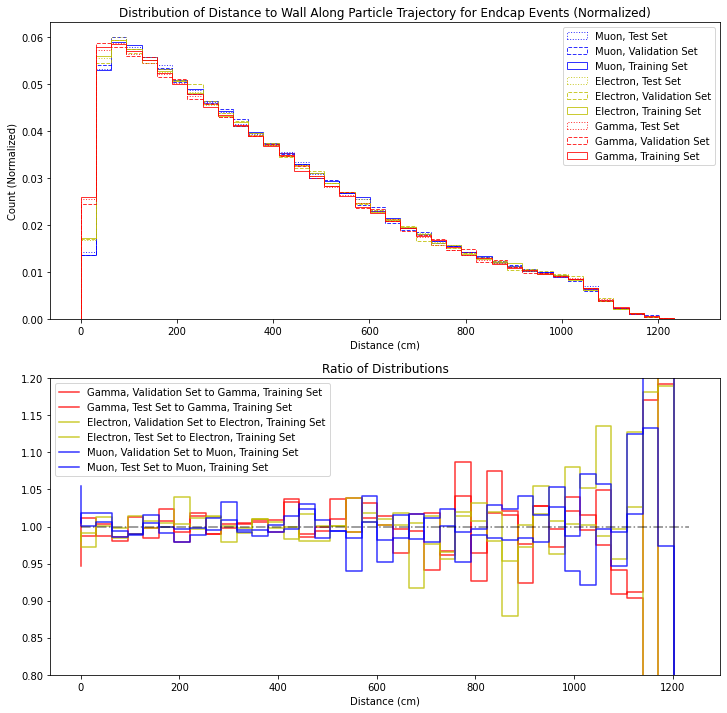

In [17]:
# Plot endcap distance to wall histogram by particle subset
patches = plot_compare_dists([endcap_train_g, endcap_val_g, endcap_test_g,
                              endcap_train_e, endcap_val_e, endcap_test_e,
                              endcap_train_m, endcap_val_m, endcap_test_m],
                            bins=40,
                            numerator_dist_idxs   = [1, 2, 4, 5, 7, 8],
                            denominator_dist_idxs = [0, 0, 3, 3, 6, 6],
                            title='Distribution of Distance to Wall Along Particle Trajectory for Endcap Events', 
                            labels=['Gamma, Training Set', 'Gamma, Validation Set', 'Gamma, Test Set',
                                    'Electron, Training Set', 'Electron, Validation Set', 'Electron, Test Set',
                                    'Muon, Training Set', 'Muon, Validation Set', 'Muon, Test Set'],
                            colors =  ['r','r','r','y','y','y','b','b','b'],
                            linestyle=['-','--',':','-','--',':','-','--',':'], 
                            ratio_range=[0.8,1.2],
                            xlabel='Distance (cm)'
                            )


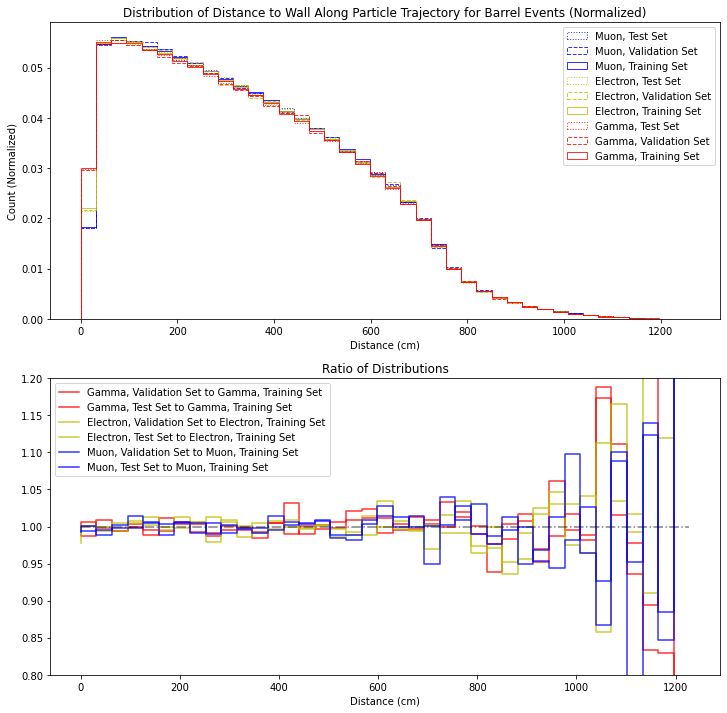

In [18]:
# Plot barrel distance to wall histogram by particle subset
patches = plot_compare_dists([barrel_train_g, barrel_val_g, barrel_test_g,
                              barrel_train_e, barrel_val_e, barrel_test_e,
                              barrel_train_m, barrel_val_m, barrel_test_m],
                            bins=40,
                            numerator_dist_idxs   = [1, 2, 4, 5, 7, 8],
                            denominator_dist_idxs = [0, 0, 3, 3, 6, 6],
                            title='Distribution of Distance to Wall Along Particle Trajectory for Barrel Events', 
                            labels=['Gamma, Training Set', 'Gamma, Validation Set', 'Gamma, Test Set',
                                    'Electron, Training Set', 'Electron, Validation Set', 'Electron, Test Set',
                                    'Muon, Training Set', 'Muon, Validation Set', 'Muon, Test Set'],
                            colors =  ['r','r','r','y','y','y','b','b','b'],
                            linestyle=['-','--',':','-','--',':','-','--',':'], 
                            ratio_range=[0.8,1.2],
                            xlabel='Distance (cm)')

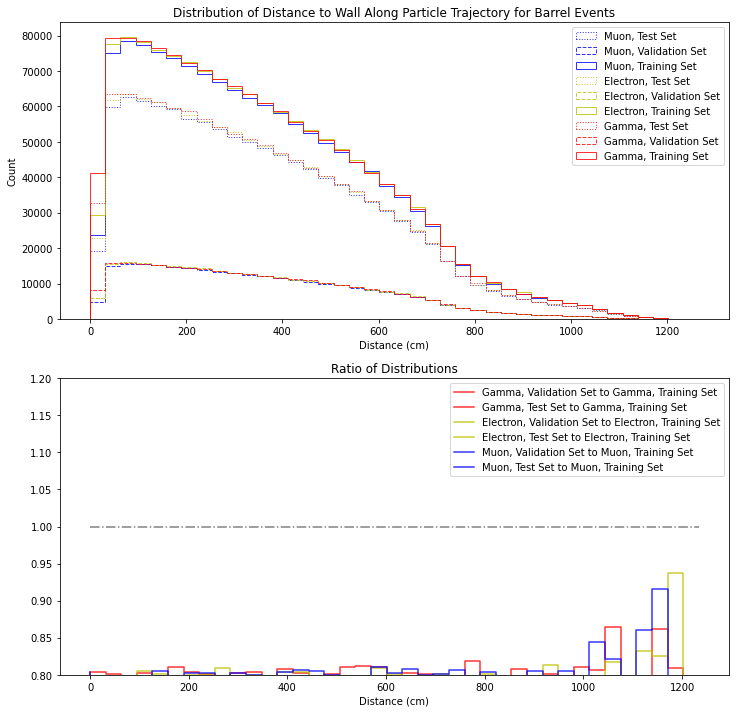

In [19]:
# Plot all distances

patches = plot_compare_dists([
                            dataset_info[0]['d_to_wall'][train_g_idxs], dataset_info[1]['d_to_wall'][val_g_idxs], dataset_info[2]['d_to_wall'][test_g_idxs],
                            dataset_info[0]['d_to_wall'][train_e_idxs], dataset_info[1]['d_to_wall'][val_e_idxs], dataset_info[2]['d_to_wall'][test_e_idxs],
                            dataset_info[0]['d_to_wall'][train_m_idxs], dataset_info[1]['d_to_wall'][val_m_idxs], dataset_info[2]['d_to_wall'][test_m_idxs]],
                            bins=40,
                            numerator_dist_idxs   = [1, 2, 4, 5, 7, 8],
                            denominator_dist_idxs = [0, 0, 3, 3, 6, 6],
                            title='Distribution of Distance to Wall Along Particle Trajectory for Barrel Events', 
                            labels=['Gamma, Training Set', 'Gamma, Validation Set', 'Gamma, Test Set',
                                    'Electron, Training Set', 'Electron, Validation Set', 'Electron, Test Set',
                                    'Muon, Training Set', 'Muon, Validation Set', 'Muon, Test Set'],
                            colors =  ['r','r','r','y','y','y','b','b','b'],
                            linestyle=['-','--',':','-','--',':','-','--',':'], 
                            ratio_range=[0.8,1.2],
                            xlabel='Distance (cm)',
                            normalized=False)

No handles with labels found to put in legend.


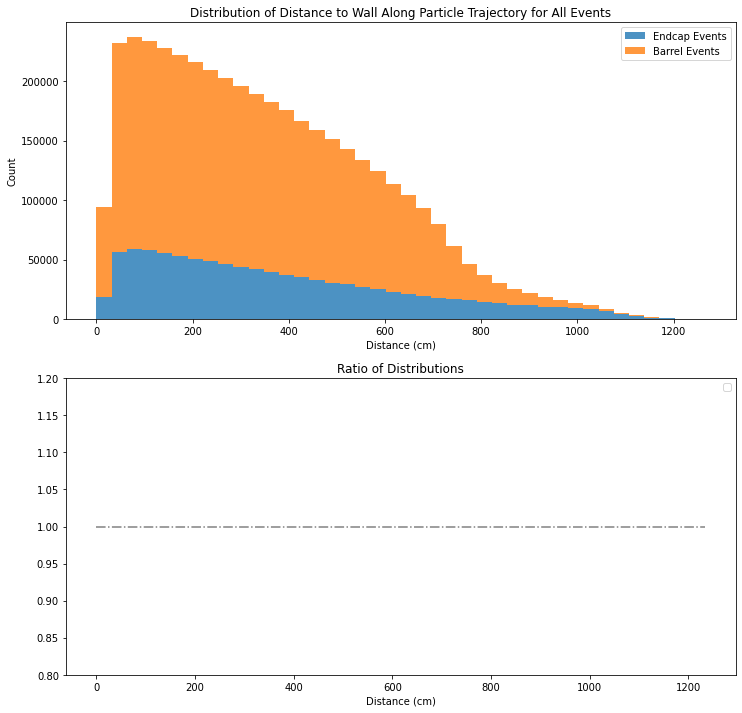

In [22]:
# Plot stacked hist for training set
patches = plot_compare_dists([
                            dataset_info[0]['d_to_wall'][endcap_train_idxs],
                            dataset_info[0]['d_to_wall'][barrel_train_idxs]],
                            bins=40,
                            numerator_dist_idxs   = [],
                            denominator_dist_idxs = [],
                            labels=['Endcap Events', 'Barrel Events'],
                            title='Distribution of Distance to Wall Along Particle Trajectory for All Events',
                            ratio_range=[0.8,1.2],
                            xlabel='Distance (cm)',
                            normalized=False,
                            histtype='barstacked')

# Times Thresholded by Charge

In [21]:
energy_bins = []

train_m_idxs = np.where(dataset_info[0]['labels']==2)[0]
val_m_idxs   = np.where(dataset_info[1]['labels']==2)[0]
test_m_idxs  = np.where(dataset_info[2]['labels']==2)[0]

train_m_energies = dataset_info[0]['energies'][train_m_idxs]
val_m_energies   = dataset_info[1]['energies'][val_m_idxs]  
test_m_energies  = dataset_info[2]['energies'][test_m_idxs]


def get_idxs_satisfying_bounds(energies, lower_bound, upper_bound):
    return np.where((lower_bound < energies) & (energies <= upper_bound))[0]

valid_train_m_energy_idxs = get_idxs_satisfying_bounds(train_m_energies, 400, 500)
valid_val_m_energy_idxs   = get_idxs_satisfying_bounds(val_m_energies, 400, 500)
valid_test_m_energy_idxs  = get_idxs_satisfying_bounds(test_m_energies, 400, 500)

# print((dataset_info[0]['energies'])[train_m_idxs[valid_train_m_energy_idxs]])

train_bin_dist_to_wall = (dataset_info[0]['d_to_wall'])[train_m_idxs[valid_train_m_energy_idxs]]
val_bin_dist_to_wall   = (dataset_info[1]['d_to_wall'])[val_m_idxs[valid_val_m_energy_idxs]]
test_bin_dist_to_wall  = (dataset_info[2]['d_to_wall'])[test_m_idxs[valid_test_m_energy_idxs]]

plt.figure()
fig,axes = plt.subplots(2,1,figsize=(12,12))
axes = axes.flatten()

plot_compare_dists(np.squeeze(np.array([train_bin_dist_to_wall, 
                                        val_bin_dist_to_wall, 
                                        test_bin_dist_to_wall])),
                    bins=30,
                    numerator_dist_idxs   = [],
                    denominator_dist_idxs = [],
                    labels=[data['name'] for data in dataset_info],
                    title='Distribution of Distance to Wall Along Particle Trajectory for $400$-$500$ MeV Events',
                    axes = axes,
                    xlabel='Distance (cm)',
                    normalized=False
                    )

/home/jtindall/.local/lib/python3.6/site-packages/ipykernel_launcher.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


<Figure size 432x288 with 0 Axes>